In [17]:
import os
import cv2
import xml.etree.ElementTree as ET
import re
import random

# Example outline for training a barcode detection model
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch import optim
import torch.nn as nn




In [18]:

def load_dataset(image_dir, annotation_dir, image_dir_negative=None, target_width=224, target_height=224):
    """
    Load dataset from image and annotation directories, resize images, and adjust bounding boxes.

    Parameters:
    - image_dir: Directory containing images with annotations (XML files).
    - annotation_dir: Directory containing XML annotations corresponding to images.
    - image_dir_negative: Optional directory containing images without annotations.
    - target_width: Target width for resizing images.
    - target_height: Target height for resizing images.

    Returns:
    - Dictionary mapping image filenames to dictionaries containing 'image' and 'boxes' (adjusted bounding boxes).
    """
    annotations = {}

    # Load positive examples (images with annotations)
    image_paths = sorted(os.listdir(image_dir))
    
    for image_file in image_paths:
        image_path = os.path.join(image_dir, image_file)
        annotation_file = os.path.join(annotation_dir, os.path.splitext(image_file)[0] + '.xml')

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to load image {image_file}")
            continue
        
        # Load annotations
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        
        boxes = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text.strip())
            ymin = int(bbox.find('ymin').text.strip())
            xmax = int(bbox.find('xmax').text.strip())
            ymax = int(bbox.find('ymax').text.strip())
     
            # Append bounding box coordinates
            boxes.append([xmin, ymin, xmax, ymax])
        
        # Resize image
        original_height, original_width = image.shape[:2]
        scale_x = target_width / original_width
        scale_y = target_height / original_height
        resized_image = cv2.resize(image, (target_width, target_height))
        
        # Adjust bounding box coordinates
        adjusted_boxes = []
        for bbox in boxes:
            adjusted_bbox = [
                int(bbox[0] * scale_x),  # xmin
                int(bbox[1] * scale_y),  # ymin
                int(bbox[2] * scale_x),  # xmax
                int(bbox[3] * scale_y)   # ymax
            ]
            adjusted_boxes.append(adjusted_bbox)

        # Store image and annotations in dictionary
        annotations[image_file] = {
            'image': resized_image,
            'boxes': adjusted_boxes
        }

    # Load negative examples (images without annotations)
    if image_dir_negative:
        image_paths_negative = sorted(os.listdir(image_dir_negative))
        
        for image_file in image_paths_negative:
            image_path = os.path.join(image_dir_negative, image_file)

            # Load image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to load image {image_file}")
                continue
                # Resize image
            original_height, original_width = image.shape[:2]
            scale_x = target_width / original_width
            scale_y = target_height / original_height
            resized_image = cv2.resize(image, (target_width, target_height))
            # No annotations for negative examples
            annotations[image_file] = {
                'image': resized_image,
                'boxes': []  # No bounding boxes for negative examples
            }
    
    return annotations

In [19]:
# Example usage
if __name__ == "__main__":
    # Example dataset paths
    image_dir = 'dataset/images/'
    annotation_dir = 'dataset/annotations/'
    image_dir_negative ='dataset/negative_images'
    
    annotations = load_dataset(image_dir, annotation_dir,image_dir_negative)
    

    
    # Print loaded annotations
    for image_file, data in annotations.items():
        print(f"Image: {image_file}, Bounding Boxes: {data['boxes']}")

Image: image0.jpg, Bounding Boxes: []
Image: image1.jpg, Bounding Boxes: [[90, 132, 110, 172]]
Image: image10.jpg, Bounding Boxes: [[37, 96, 64, 118]]
Image: image100.jpg, Bounding Boxes: [[212, 20, 223, 56]]
Image: image101.jpg, Bounding Boxes: [[212, 20, 223, 54]]
Image: image102.jpg, Bounding Boxes: [[117, 21, 144, 61]]
Image: image103.jpg, Bounding Boxes: [[117, 21, 144, 61]]
Image: image104.jpg, Bounding Boxes: [[117, 21, 144, 61]]
Image: image105.jpg, Bounding Boxes: [[117, 21, 144, 61]]
Image: image106.jpg, Bounding Boxes: [[130, 46, 155, 87]]
Image: image107.jpg, Bounding Boxes: [[130, 47, 156, 88]]
Image: image108.jpg, Bounding Boxes: [[147, 99, 178, 126]]
Image: image109.jpg, Bounding Boxes: [[147, 99, 178, 126]]
Image: image11.jpg, Bounding Boxes: [[32, 110, 67, 145]]
Image: image110.jpg, Bounding Boxes: [[78, 51, 125, 97]]
Image: image111.jpg, Bounding Boxes: [[147, 99, 178, 126]]
Image: image112.jpg, Bounding Boxes: [[102, 100, 134, 133]]
Image: image113.jpg, Bounding Boxe

In [20]:

validation_dataset = {}

for i in range(5):
    random_key = random.choice(list(annotations.keys()))
    removed_value = annotations.pop(random_key, None)
    validation_dataset[random_key] = removed_value


In [21]:
# Define your CNN model
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define your model architecture here

    def forward(self, x):
        # Implement forward pass of your model
        return x  # Adjust based on your model architecture

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64 * 28 * 28, 256)  # Adjust input size based on your image dimensions after pooling
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)  # Output layer for bounding box coordinates
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 28 * 28)  # Adjust size based on your image dimensions after pooling
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer, no activation for bounding box prediction
        
        return x

In [23]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
        self.dropout = nn.Dropout(0.5)  # Adjust dropout rate
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [25]:
# Example training loop (assuming you have a model defined)
num_epochs = 10

# Initialize your CNN model
model = SimpleCNN()
model = ImprovedCNN()
# Assuming you have an optimizer (e.g., Adam) and learning rate
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
    # Shuffle dataset for each epoch (if desired)
    keys = list(annotations.keys())
    random.shuffle(keys)
    
    for key in keys:
        image_data = annotations[key]
        image = image_data['image']
        boxes = image_data['boxes']
        
        # Implement your training steps here
        # Example:
        # 1. Forward pass through the model
        # 2. Compute loss (using boxes and predicted bounding boxes)
        # 3. Backward pass and update weights
           # Convert image and boxes to tensors
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        
        #target_boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        ##Test
        target_boxes_tensor = []
        for box in boxes:
            if box:
                target_boxes_tensor.append(torch.tensor(box, dtype=torch.float32))
            else:
                # Append a placeholder tensor of zeros if the list is empty
                target_boxes_tensor.append(torch.zeros((1, 4), dtype=torch.float32))

        # Stack target_boxes_tensor along batch dimension if it's not empty
        if target_boxes_tensor:
            target_boxes_tensor = torch.stack(target_boxes_tensor, dim=0)
        else:
            # Create a placeholder tensor if all are empty
            target_boxes_tensor = torch.zeros((1, 4), dtype=torch.float32)

        ##Test
        print(image_tensor.shape)
        # Forward pass
        predicted_boxes = model(image_tensor)
        
        # Compute loss
        loss = F.smooth_l1_loss(predicted_boxes, target_boxes_tensor)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
          # Print loss or log it as needed
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
        
# After training, evaluate on validation dataset
for key, value in validation_dataset.items():
    image = value['image']
    boxes = value['boxes']
    
    # Perform inference with your trained model and evaluate performance
    # Example:
    # 1. Forward pass to get predicted bounding boxes
    # 2. Compute metrics (IoU, mAP, etc.) to evaluate performanc

torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 0.015867015346884727
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 7.694262504577637
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 125.45652770996094
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 99.2325439453125
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 17.93035888671875
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 144.44976806640625
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 8.695213317871094
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 18.30411148071289
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 93.01228332519531
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 72.63671875
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 75.2810287475586
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 47.436798095703125
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 47.57082748413086
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 105.86802673339844
torch.Size([1, 3, 224, 224])
Epoch [1/10], Loss: 56.83943557739

In [ ]:
def inference(model, validation_dataset):
    model.eval()  # Set the model to evaluation mode
    predictions = {}
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for key, data in validation_dataset.items():
            image = data['image']
            image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            
            # Forward pass to get predicted bounding boxes
            predicted_boxes = model(image_tensor).squeeze(0).tolist()  # Convert to list for easier handling
            
            # Store predictions
            predictions[key] = predicted_boxes
    
    return predictions

def compute_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])
    
    intersection_area = max(0, x2_min - x1_max) * max(0, y1_max - y2_min)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area if union_area != 0 else 0
    
    return iou

# Perform inference
predictions = inference(model, validation_dataset)

# Compute IoU for the validation dataset
for key in validation_dataset.keys():
    true_boxes = validation_dataset[key]['boxes']
    predicted_boxes = predictions[key]
    
    for true_box in true_boxes:
        iou = compute_iou(true_box, predicted_boxes)
        print(f"Image: {key}, IoU: {iou}")

# Placeholder for mAP computation
# Example to compute mAP for the validation dataset
# Note: This is a simplified example and may need adaptation for your specific use case
true_boxes_list = [data['boxes'] for data in validation_dataset.values()]
predicted_boxes_list = [predictions[key] for key in validation_dataset.keys()]

# Placeholder function for computing mAP
# Implement or use existing libraries for accurate mAP computation
# map_score = compute_map(true_boxes_list, predicted_boxes_list)
# print(f"mAP: {map_score}")



Image: image8.jpg, IoU: 0.39877876364955667
Image: image52.jpg, IoU: 0.0
Image: image81.jpg, IoU: 0.0
Image: image87.jpg, IoU: 2.854471502279042
Image: image99.jpg, IoU: 0.0


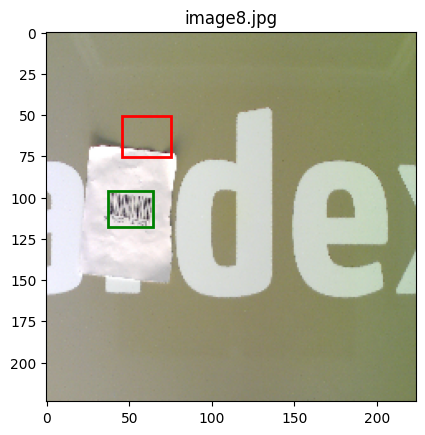

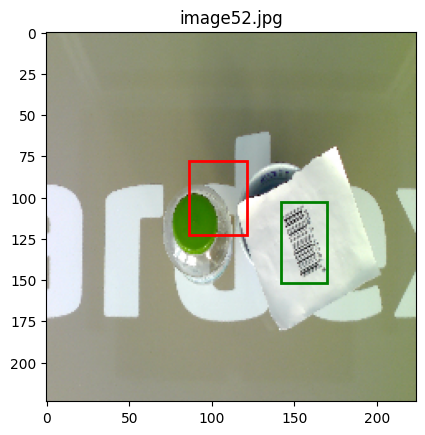

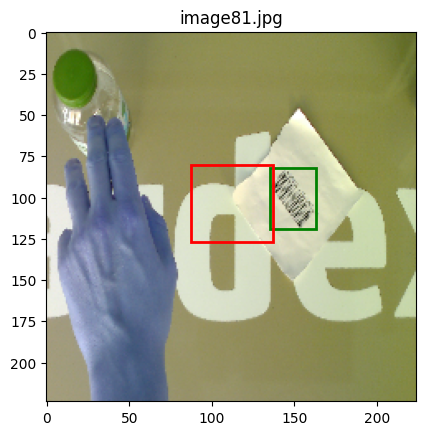

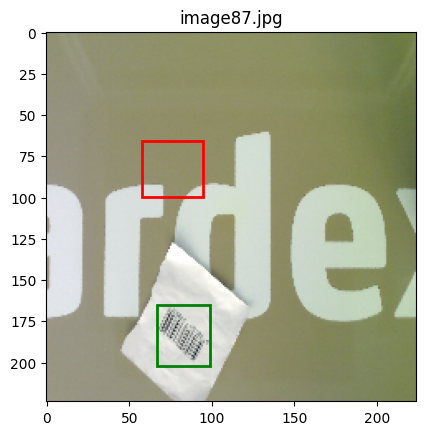

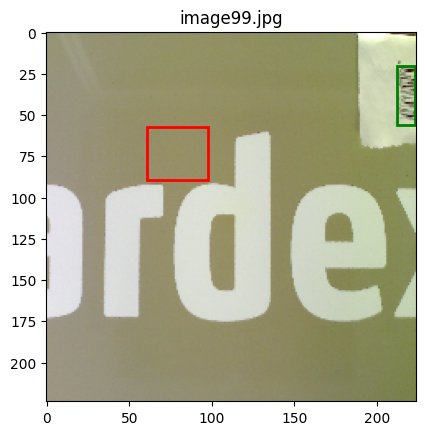

In [ ]:

import matplotlib.pyplot as plt

def visualize_boxes(image, true_boxes, predicted_boxes, image_name):
    plt.imshow(image)
    ax = plt.gca()
    
    # Ensure true_boxes is a list of lists
    if not isinstance(true_boxes[0], list):
        true_boxes = [true_boxes]
    
    # Ensure predicted_boxes is a list of lists
    if not isinstance(predicted_boxes[0], list):
        predicted_boxes = [predicted_boxes]
    
    # Plot true boxes
    for true_box in true_boxes:
        true_rect = plt.Rectangle((true_box[0], true_box[1]), true_box[2] - true_box[0], true_box[3] - true_box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(true_rect)
    
    # Plot predicted boxes
    for predicted_box in predicted_boxes:
        predicted_rect = plt.Rectangle((predicted_box[0], predicted_box[1]), predicted_box[2] - predicted_box[0], predicted_box[3] - predicted_box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(predicted_rect)
    
    plt.title(image_name)
    plt.show()

# Visualize for all validation images
for image_name, data in validation_dataset.items():
    image = data['image']
    true_boxes = data['boxes']
    predicted_boxes = predictions[image_name]
    
    visualize_boxes(image, true_boxes, predicted_boxes, image_name)
